## Latency reguation rule for spiking neural networks (Garamov K.A., Lobov S.A.)
This notebook provides experiments from paper - LINK <br/>
It includes visuals and a simple playground as well <br/>
In order to obtain the exact implementation of this rule, see ```Delayed_synapse``` class at ``Prototype/synaptics.py`` - https://github.com/iamkg0/rustyspikes/blob/main/Prototype/synaptics.py <br/>

In [1]:
from rustyspikes import *
res = .1

### The essence of the rule
Here we synchronize presynaptic spike with postsynaptic. Single synapse synchronization, just to be sure that the model works in general. <br/>
No transmembrane dynamics just yet, timed spikes only, with <b>no influence from synapse</b>.

In [8]:
def exp11(rt=50, aw_in=0, aw_out=6, tau=10, synaptic_limit=1, scale=1, delay=10, max_delay=100, b=0):
    # initializes the model
    snn = SNNModel()
    output = Spikes_at_will(awaiting_time=aw_out, refresh_time=rt, tau=tau, synaptic_limit=synaptic_limit)
    input = Spikes_at_will(awaiting_time=aw_in, refresh_time=rt, tau=tau, synaptic_limit=synaptic_limit)
    synapse = Delayed_synapse(input, output, scale=scale, delay=delay, max_delay=max_delay, b=b)
    snn.add_neuron(output)
    snn.add_neuron(input)
    snn.add_synapse(synapse)
    snn.reload_graph()
    return snn

def protocol_11(model, time=100, plot=True, return_gatherer=False):
    delay = []
    dd = []
    gatherer = Gatherer(model)
    t = np.arange(int(time/res)) * res
    for i in t:
        model.tick()
        if plot:
            gatherer.gather_stats()
        delay.append(model.syn_by_edge[1,0].delay)
        dd.append(model.syn_by_edge[1,0].dd)
    if plot:
        draw_stats_gatherer(*gatherer.get_stats(pre_ids=[1], post_ids=[0]), t, fheight=12, fwidth=16, dpi=50)
    if return_gatherer:
        return model, delay, np.array(dd), gatherer
    else:
        return model, delay, np.array(dd)

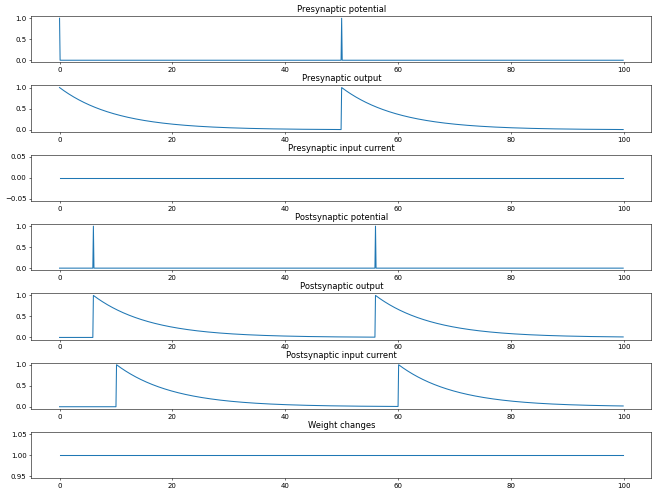

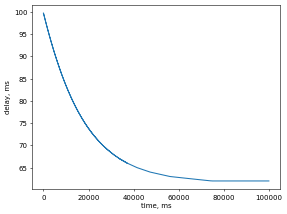

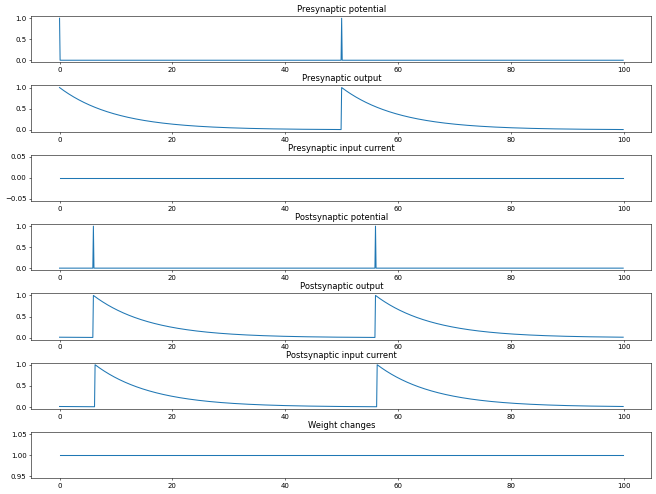

In [15]:
model_11 = exp11() # Init the model
model_11, delay, *_ = protocol_11(model_11) # Before training
train_time = 100000
model_11, delay, *_ = protocol_11(model_11, time=train_time, plot=False, return_gatherer=False) # Training procedure
f = plt.figure() # This figure will plot delay changes during training
plt.xlabel('time, ms')
plt.ylabel('delay, ms')
f.set_dpi(50)
plt.plot(np.arange(int(train_time / res)) * res, delay)
plt.show()
model_11, delay, *_ = protocol_11(model_11) # Result

### <b>b value</b>
Now, let us see that depolarization bias <b><i>b</i></b> is robust. Let's see how it works with Izhikevich neuron. We've got just one presynaptic input, so that means the goal is to find <i>b</i> that keeps delay steady

In [2]:
def exp12(sc=7, rt=100, aw=1, tau=10, synaptic_limit=1, delay=20, max_delay=100, d_lr=1, b=6.7):
    # OPTIMAL PARAMS FOR 0 IMPACT:
    # rt0 = 100 msec, aw = 1 msec, tau = 10, delay = 0 (any, in fact), b = 6.7
    snn = SNNModel()
    output = Izhikevich(tau=tau, synaptic_limit=synaptic_limit)
    input = Spikes_at_will(awaiting_time=aw, refresh_time=rt, synaptic_limit=synaptic_limit, tau=tau)
    syn = Delayed_synapse(input, output, scale=sc, delay=delay, max_delay=max_delay, d_lr=d_lr, b=b)
    snn.add_neuron(output)
    snn.add_neuron(input)
    snn.add_synapse(syn)
    snn.reload_graph()
    return snn

def protocol_12(model, time=100, plot=True, return_gatherer=False):
    delay = []
    dd = []
    gatherer = Gatherer(model)
    t = np.arange(int(time/res)) * res
    for i in t:
        model.tick()
        if plot:
            gatherer.gather_stats()
        delay.append(model.syn_by_edge[1,0].delay)
        dd.append(model.syn_by_edge[1,0].dd)
    if plot:
        draw_stats_gatherer(*gatherer.get_stats(pre_ids=[1], post_ids=[0]), t, fheight=12, fwidth=16, dpi=50)
    if return_gatherer:
        return model, delay, np.array(dd), gatherer
    else:
        return model, delay, np.array(dd)

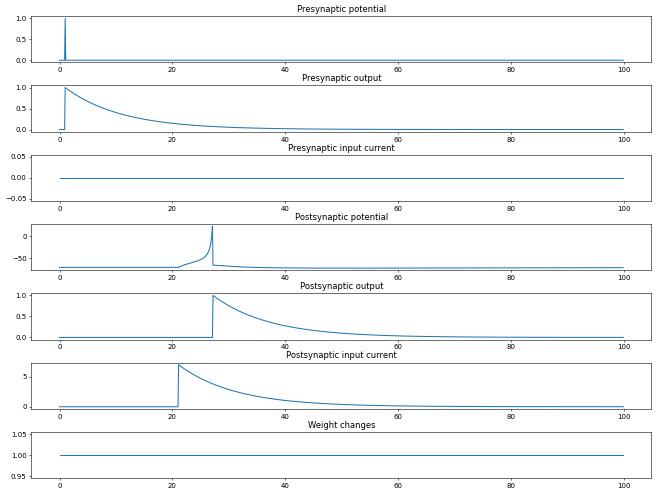

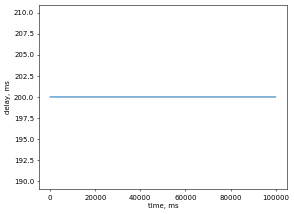

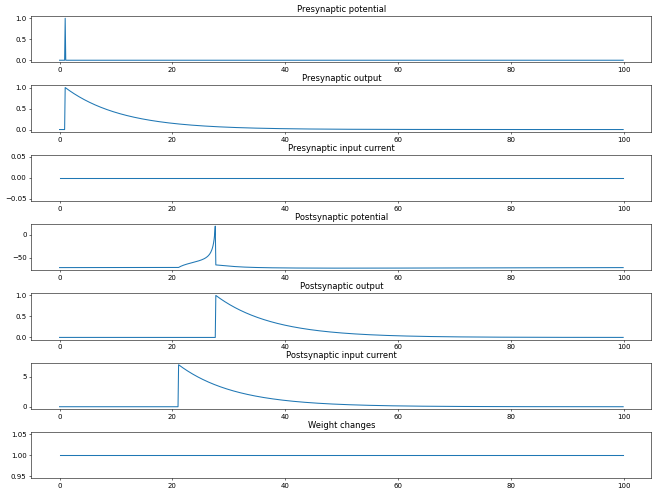

In [19]:
model_12 = exp12()
model_12, delay, *_ = protocol_12(model_12) # Before training
train_time = 100000
model_12, delay, *_ = protocol_12(model_12, time=train_time, plot=False, return_gatherer=False) # Training procedure
f = plt.figure() # This figure will plot delay changes during training
plt.xlabel('time, ms')
plt.ylabel('delay, ms')
f.set_dpi(50)
plt.plot(np.arange(int(train_time / res)) * res, delay)
plt.show()
model_12, delay, *_ = protocol_12(model_12) # Result

## Now, let's prove our model works with multidimensional neuron!
We build simple dynamic pattern and feed it to Izhikevich neuron, so it can learn it

In [2]:
def exp21(sc=7, num_inputs=10, tau=10, synaptic_limit=1, delay=1, max_delay=100, d_lr=.1, b=4.6):
    snn = SNNModel()
    output = Izhikevich(tau=tau, synaptic_limit=synaptic_limit)
    snn.add_neuron(output)
    for saw in range(num_inputs):
        neu = Spikes_at_will(tau=tau, synaptic_limit=synaptic_limit)
        snn.add_neuron(neu)
        syn = Delayed_synapse(neu, output, scale=sc, delay=delay, max_delay=max_delay, d_lr=d_lr, b=b)
        snn.add_synapse(syn)
    snn.reload_graph()
    return snn

def run_protocol(model, sampler, sample_time=150, interval=6, runs=3, lr=.1, d_lr=None, test=False,
                 freeze_delays=False, gather_data=False, plot=False, plast_type=None, return_gatherer=False, gather_delays=True,
                 logger=None, init_weights=None, stick_del_w_to_one=True):
    learning_rule = plast_type
    if not test:
        model.set_rule_to_all(plast_type)
        model.set_lr_to_all(lr)
        if d_lr:
            model.set_d_lr(d_lr)
    else:
        model.set_rule_to_all(None)
        model.set_lr_to_all(0)
        if d_lr:
            model.set_d_lr(0)
    delay = [[] for i in range(len(model.show_config()['Neurons'])-1)]
    dd = [[] for i in range(len(model.show_config()['Neurons'])-1)]
    num_spikes = [0 for i in range(len(sampler))]

    if gather_data:
        gatherer = Gatherer(model)

    if test:
        length = len(sampler)
    else:
        length = 1

    for p in range(length):
        sample = sampler[p]
        for run in range(runs):
            aw = 1
            for neu in sample:
                model.neurons[neu].awaiting_time = aw
                model.neurons[neu].refresh()
                aw += interval
            for t in np.arange(int(sample_time/res)) * res:
                model.tick(freeze_delays=freeze_delays)
                if model.neurons[0].get_spike_status():
                    num_spikes[p] += 1
                if gather_data:
                    gatherer.gather_stats()
                if not freeze_delays:
                    if gather_delays:
                        for edge in range(1, len(model.show_config()['Neurons'])):
                            #print(np.array(delay).shape, np.array(dd).shape)
                            delay[edge-1].append(model.syn_by_edge[edge,0].delay)
                            dd[edge-1].append(model.syn_by_edge[edge,0].dd)
    if plot and gather_data:
        draw_stats_gatherer(*gatherer.get_stats(pre_ids=list(range(1, len(model.show_config()['Neurons']))),
                                                post_ids=[0]), time_range=sample_time*runs*(length), resolution=res)
    
    if logger:
        # values to write:
        input_size = len(model.get_presyn_neurons_ids(*model.get_output_ids()))
        aw_time = interval
        #sample_time
        #lr
        #runs
        #d_lr
        scale = model.get_first_synapse().scale
        rt = model.neurons[1].refresh_time
        num_patterns = len(sampler)
        synaptic_limit = model.neurons[1].synaptic_limit
        slow_var_limit = model.get_first_synapse().slow_variable_limit
        slow_tau = model.get_first_synapse().slow_tau
        forget_tau = model.get_first_synapse().forget_tau
        spikes = num_spikes
        noise = model.get_output_neurons()[0].noise
        if type(model.get_first_synapse()) == Delayed_synapse:
            b = model.get_first_synapse().b
            max_delay = model.get_first_synapse().max_delay
        else:
            b = None
            max_delay = None

        if stick_del_w_to_one and learning_rule == 'delayed':
            init_weights = 1

        sample_pack = [input_size, aw_time, sample_time, lr, runs, d_lr, scale, rt,
                            num_patterns, synaptic_limit, slow_var_limit, slow_tau, forget_tau,
                            spikes, b, max_delay, learning_rule, noise, init_weights]
        for i in range(len(sample_pack)):
            if sample_pack[i] == None:
                sample_pack[i] = '-'
        logger.write_sample(sample_pack)

    if return_gatherer and gather_data:
        return model, np.array(delay).T, np.array(dd), np.array(num_spikes), gatherer
    else:
        return model, np.array(delay).T, np.array(dd), np.array(num_spikes)
    
def cfg_slicer(cfg):
    '''
    No, im not ashamed
    '''
    configs = []
    for input_size in cfg['input_size']:
        for aw_time in cfg['aw_time']:
            for sample_time in cfg['sample_time']:
                for lr in cfg['lr']:
                    for runs in cfg['runs']:
                        for d_lr in cfg['d_lr']:
                            for scale in cfg['scale']:
                                for rt in cfg['rt']:
                                    for num_patterns in cfg['num_rand_patterns']:
                                        for synaptic_limit in cfg['synaptic_limit']:
                                            for slow_tau in cfg['slow_tau']:
                                                for forget_tau in cfg['forget_tau']:
                                                    for b in cfg['b']:
                                                        for max_delay in cfg['max_delay']:
                                                            for learning_rule in cfg['learning_rule']:
                                                                for noise in cfg['noise']:
                                                                    for weights in cfg['weights']:
                                                                        configs.append(
                                                                            {
                                                                                'input_size': input_size,
                                                                                'aw_time': aw_time,
                                                                                'sample_time': sample_time,
                                                                                'lr': lr,
                                                                                'runs': runs,
                                                                                'd_lr': d_lr,
                                                                                'scale': scale,
                                                                                'rt': rt,
                                                                                'num_patterns': num_patterns,
                                                                                'synaptic_limit': synaptic_limit,
                                                                                'slow_tau': slow_tau,
                                                                                'forget_tau': forget_tau,
                                                                                'b': b,
                                                                                'max_delay': max_delay,
                                                                                'learning_rule': learning_rule,
                                                                                'noise': noise,
                                                                                'weights': weights
                                                                            }
                                                                        )
    return configs

In [ ]:
np.random.seed(42) #for reproducibility
log_path = r'C:\Users\User\Desktop'
log_name = 'output.csv'
log = LogHandler(path=log_path, filename=log_name)

# PROTOCOL CONFIGURATION

config = {
    'input_size': [5],
    'aw_time': [5],
    'sample_time': [150],
    'lr': [.01],
    'runs': [250],
    'd_lr': [10],
    'scale': [0.5, 0.6, 0.7, 0.8, 0.9, 1, 1.1, 1.2, 1.3],
    'rt': [250],
    'num_rand_patterns': [5],
    'synaptic_limit': [1],
    'slow_tau': [100],
    'forget_tau': [100],
    'b': [7],
    'max_delay': [100],
    'learning_rule': ['pair_stdp', 't_stdp', 'delayed'],
    'noise': [0.5, 0.7, 1, 1.3],
    'weights': [(1, 1)],
}
del_w_to_one = True

num_tries = 1
for i in config:
    num_tries *= len(config[i])

patterns, num_inputs, num_patterns = sampler(num_inputs=config['input_size'][0], num_rand_patterns=config['num_rand_patterns'][0])
log.create()
log.define_cols(('input_size', 'aw_time', 'sample_time', 'lr', 'runs', 'd_lr', 'scale', 'rt',
                            'num_patterns', 'synaptic_limit', 'slow_var_limit', 'slow_tau', 'forget_tau',
                            'spikes (0 is gt)', 'b', 'max_delay', 'learning_rule', 'noise', 'init_weights'))
log.comment([*patterns.values()])
print(f'patterns are: {patterns}')

attempt_num = 0
cfgs = cfg_slicer(config)
for cfg in cfgs:

    attempt_num += 1
    print('\n Calculation in progress...')
    print(f'Run {attempt_num}/{num_tries}')

    if cfg['learning_rule'] == 'delayed':
        delayed = True
    else:
        delayed = False
    model = one_neu_dynamics(num_input=cfg['input_size'], scale=cfg['scale'], rt=cfg['rt']  , interval=cfg['aw_time'],
                            learning_rule=cfg['learning_rule'], delayed=delayed,
                            lr=cfg['lr'], tau=30, d_lr=.1, synaptic_limit=cfg['synaptic_limit'],
                            slow_variable_limit=cfg['synaptic_limit'], max_delay=cfg['max_delay'], b=cfg['b'],
                            slow_tau=cfg['slow_tau'], forget_tau=cfg['forget_tau'], delay=0,
                            noise=cfg['noise'], weights=cfg['weights'], stick_del_w_to_one=del_w_to_one)
    
    # TRAIN
    model, *_ = run_protocol(model, sampler=patterns, sample_time=cfg['sample_time'], interval=cfg['aw_time'],
                    runs=cfg['runs'], lr=cfg['lr'], d_lr=cfg['d_lr'], test=False,
                    freeze_delays=False, gather_data=False, plot=False, plast_type=cfg['learning_rule'],
                    return_gatherer=False, gather_delays=False, logger=None, init_weights=cfg['weights'],
                    stick_del_w_to_one=del_w_to_one)

    # TEST
    model, *_ = run_protocol(model, sampler=patterns, sample_time=cfg['sample_time'], interval=cfg['aw_time'],
                    runs=cfg['runs'], lr=cfg['lr'], d_lr=cfg['d_lr'], test=True,
                    freeze_delays=False, gather_data=False, plot=False, plast_type=cfg['learning_rule'],
                    return_gatherer=False, gather_delays=False, logger=log, init_weights=cfg['weights'],
                    stick_del_w_to_one=del_w_to_one)
    
print('Done!')

In [ ]:
df = pd.read_csv(r'C:\Users\User\Desktop\output.csv', comment='#', delimiter='\t')
runs = df['runs'][0]
df['spikes (0 is gt)'] = df['spikes (0 is gt)'].apply(lambda x: np.array(eval(x)), 0)
sps = np.stack(df['spikes (0 is gt)'], axis=0)

In [ ]:
freq_known = sps[:,0]
freq_unknown = np.sum(sps[:,1:], axis=1) / 4
Q = np.divide(2*freq_known, (freq_known + freq_unknown)) - 1
freq_unknown.shape

ai = np.where(Q>.3)[0]
a = sps[ai]
bi = np.where(np.max(a[:, 1:], axis=1) < a[:,0]-100)[0]
b = a[bi]
ci = np.where(np.sum(b, axis=1) > 100)[0]
filtered = df.loc[[*ai[bi[ci]].tolist()]]
filtered[['runs', 'num_patterns', 'spikes (0 is gt)', 'learning_rule']]
delayed_idxs = df.index[df['learning_rule'] == 'delayed'].tolist()
pair_idxs = df.index[df['learning_rule'] == 'pair_stdp'].tolist()
t_idxs = df.index[df['learning_rule'] == 't_stdp'].tolist()
strdp_idxs = df.index[df['learning_rule'] == 'strdp'].tolist()
delayed_n = np.sum(sps[delayed_idxs], axis=1)
pair_n = np.sum(sps[pair_idxs], axis=1)
t_n = np.sum(sps[t_idxs], axis=1)
strdp_n = np.sum(sps[strdp_idxs], axis=1)

In [ ]:
pointsize = 2
all_n = sps[:,0] / runs
plt.figure(dpi=300)
plt.grid(visible=True, which='major', linestyle=':')
plt.scatter(all_n[delayed_idxs], Q[delayed_idxs], s=pointsize, label='delayed')
plt.scatter(all_n[pair_idxs], Q[pair_idxs], s=pointsize, label='pair stdp')
plt.scatter(all_n[t_n], Q[t_n], s=pointsize, label='tstdp')
plt.scatter(all_n[strdp_n], Q[strdp_n], s=pointsize, label='strdp')
plt.ylim((-1, 1))
plt.xlim((0, 2))
plt.xlabel('P')
plt.ylabel('Q')
plt.legend(markerscale=5)
plt.show()

In [ ]:
pointsize = 20
all_n = sps[:,0] / runs
plt.figure(dpi=300)
plt.grid(visible=True, which='major', linestyle=':')
plt.scatter(all_n[delayed_idxs], Q[delayed_idxs], s=pointsize, label='delayed')
plt.scatter(all_n[pair_idxs], Q[pair_idxs], s=pointsize, label='pair stdp')
plt.scatter(all_n[t_n], Q[t_n], s=pointsize, label='tstdp')
plt.scatter(all_n[strdp_n], Q[strdp_n], s=pointsize, label='strdp')
plt.ylim((0.0, .45))
plt.xlim((0.85, 1.15))
plt.xlabel('P')
plt.ylabel('Q')
plt.legend(markerscale=1.5)
plt.show()

Demonstration

In [ ]:
demo = delayed_3_to_1(out_type='IZH')
demo.set_scale(1.4)
demo.syn_by_edge[0, 3].delay = 40
demo.syn_by_edge[1, 3].delay = 120
demo.syn_by_edge[2, 3].delay = 200
gath = Gatherer(demo)
for i in range(2000):
    demo.tick()
    gath.gather_stats()
draw_stats_gatherer(*gath.get_stats(), time_range=np.arange(200*10)*.1)

In [ ]:
demo1 = delayed_3_to_1(out_type='IZH')
demo1.set_scale(1.4)
demo1.syn_by_edge[0, 3].delay = 100
demo1.syn_by_edge[1, 3].delay = 60
demo1.syn_by_edge[2, 3].delay = 20
print(demo1.syn_by_edge[1, 3].delay)
gath1 = Gatherer(demo1)
for i in range(2000):
    demo1.tick()
    gath1.gather_stats()
draw_stats_gatherer(*gath1.get_stats(), time_range=np.arange(200*10)*.1)

Here's how delays are affected by <i>b</i>

In [44]:
def protocol_b(model, interval=10, train_time=100, lr=1, rt=150, noise=0):
    for i in range(len(model.syn_by_edge)):
        model[i+1].awaiting_time = i * interval
        model[i+1].refresh_time = rt
    model[0].noise = noise
    model.set_lr_to_all(lr)
    t = np.arange(int(train_time/res)) * res
    # deltas = [[] for i in range(len(model.syn_by_edge))]
    for i in t:
        model.tick()
        # for i in range(len(model.syn_by_edge.values())):
        #     deltas[i].append(model.syn_by_edge[i+1, 0].delay)
    delays = []
    for i in model.syn_by_edge.values():
        delays.append(i.delay)
    # plt.plot(np.array(deltas).T)
    # plt.show()
    return np.array(delays)

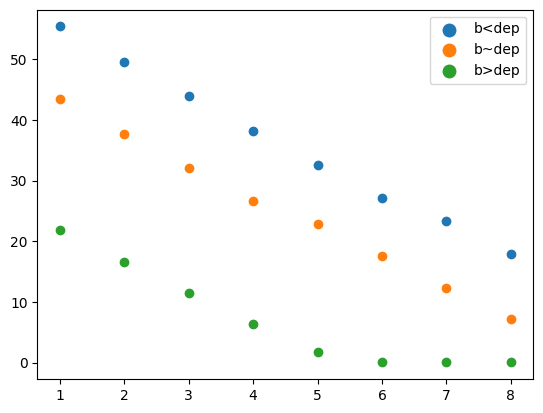

In [45]:
res=.1
num_inputs = 8
interval = 6
scale = 2.5
noise = .5
train_time = 1000000
rt = 150
lr = 1
max_del = 100
b_less_dep = exp21(sc=scale, num_inputs=num_inputs, tau=10, synaptic_limit=1, delay=10, max_delay=max_del, d_lr=lr, b=4.5)
b_close_dep = exp21(sc=scale, num_inputs=num_inputs, tau=10, synaptic_limit=1, delay=10, max_delay=max_del, d_lr=lr, b=6.)
b_greater_dep = exp21(sc=scale, num_inputs=num_inputs, tau=10, synaptic_limit=1, delay=10, max_delay=max_del, d_lr=lr, b=7.5)
delays_less = protocol_b(b_less_dep, interval=interval, train_time=train_time, lr=lr, rt=rt, noise=noise)
delays_close = protocol_b(b_close_dep, interval=interval, train_time=train_time, lr=lr, rt=rt, noise=noise)
delays_greater = protocol_b(b_greater_dep, interval=interval, train_time=train_time, lr=lr, rt=rt, noise=noise)
plt.figure()
plt.scatter(list(range(1,num_inputs+1)),delays_less*res, label='b<dep')
plt.scatter(list(range(1,num_inputs+1)),delays_close*res, label='b~dep')
plt.scatter(list(range(1,num_inputs+1)),delays_greater*res, label='b>dep')
plt.legend(markerscale=1.5)
plt.show()

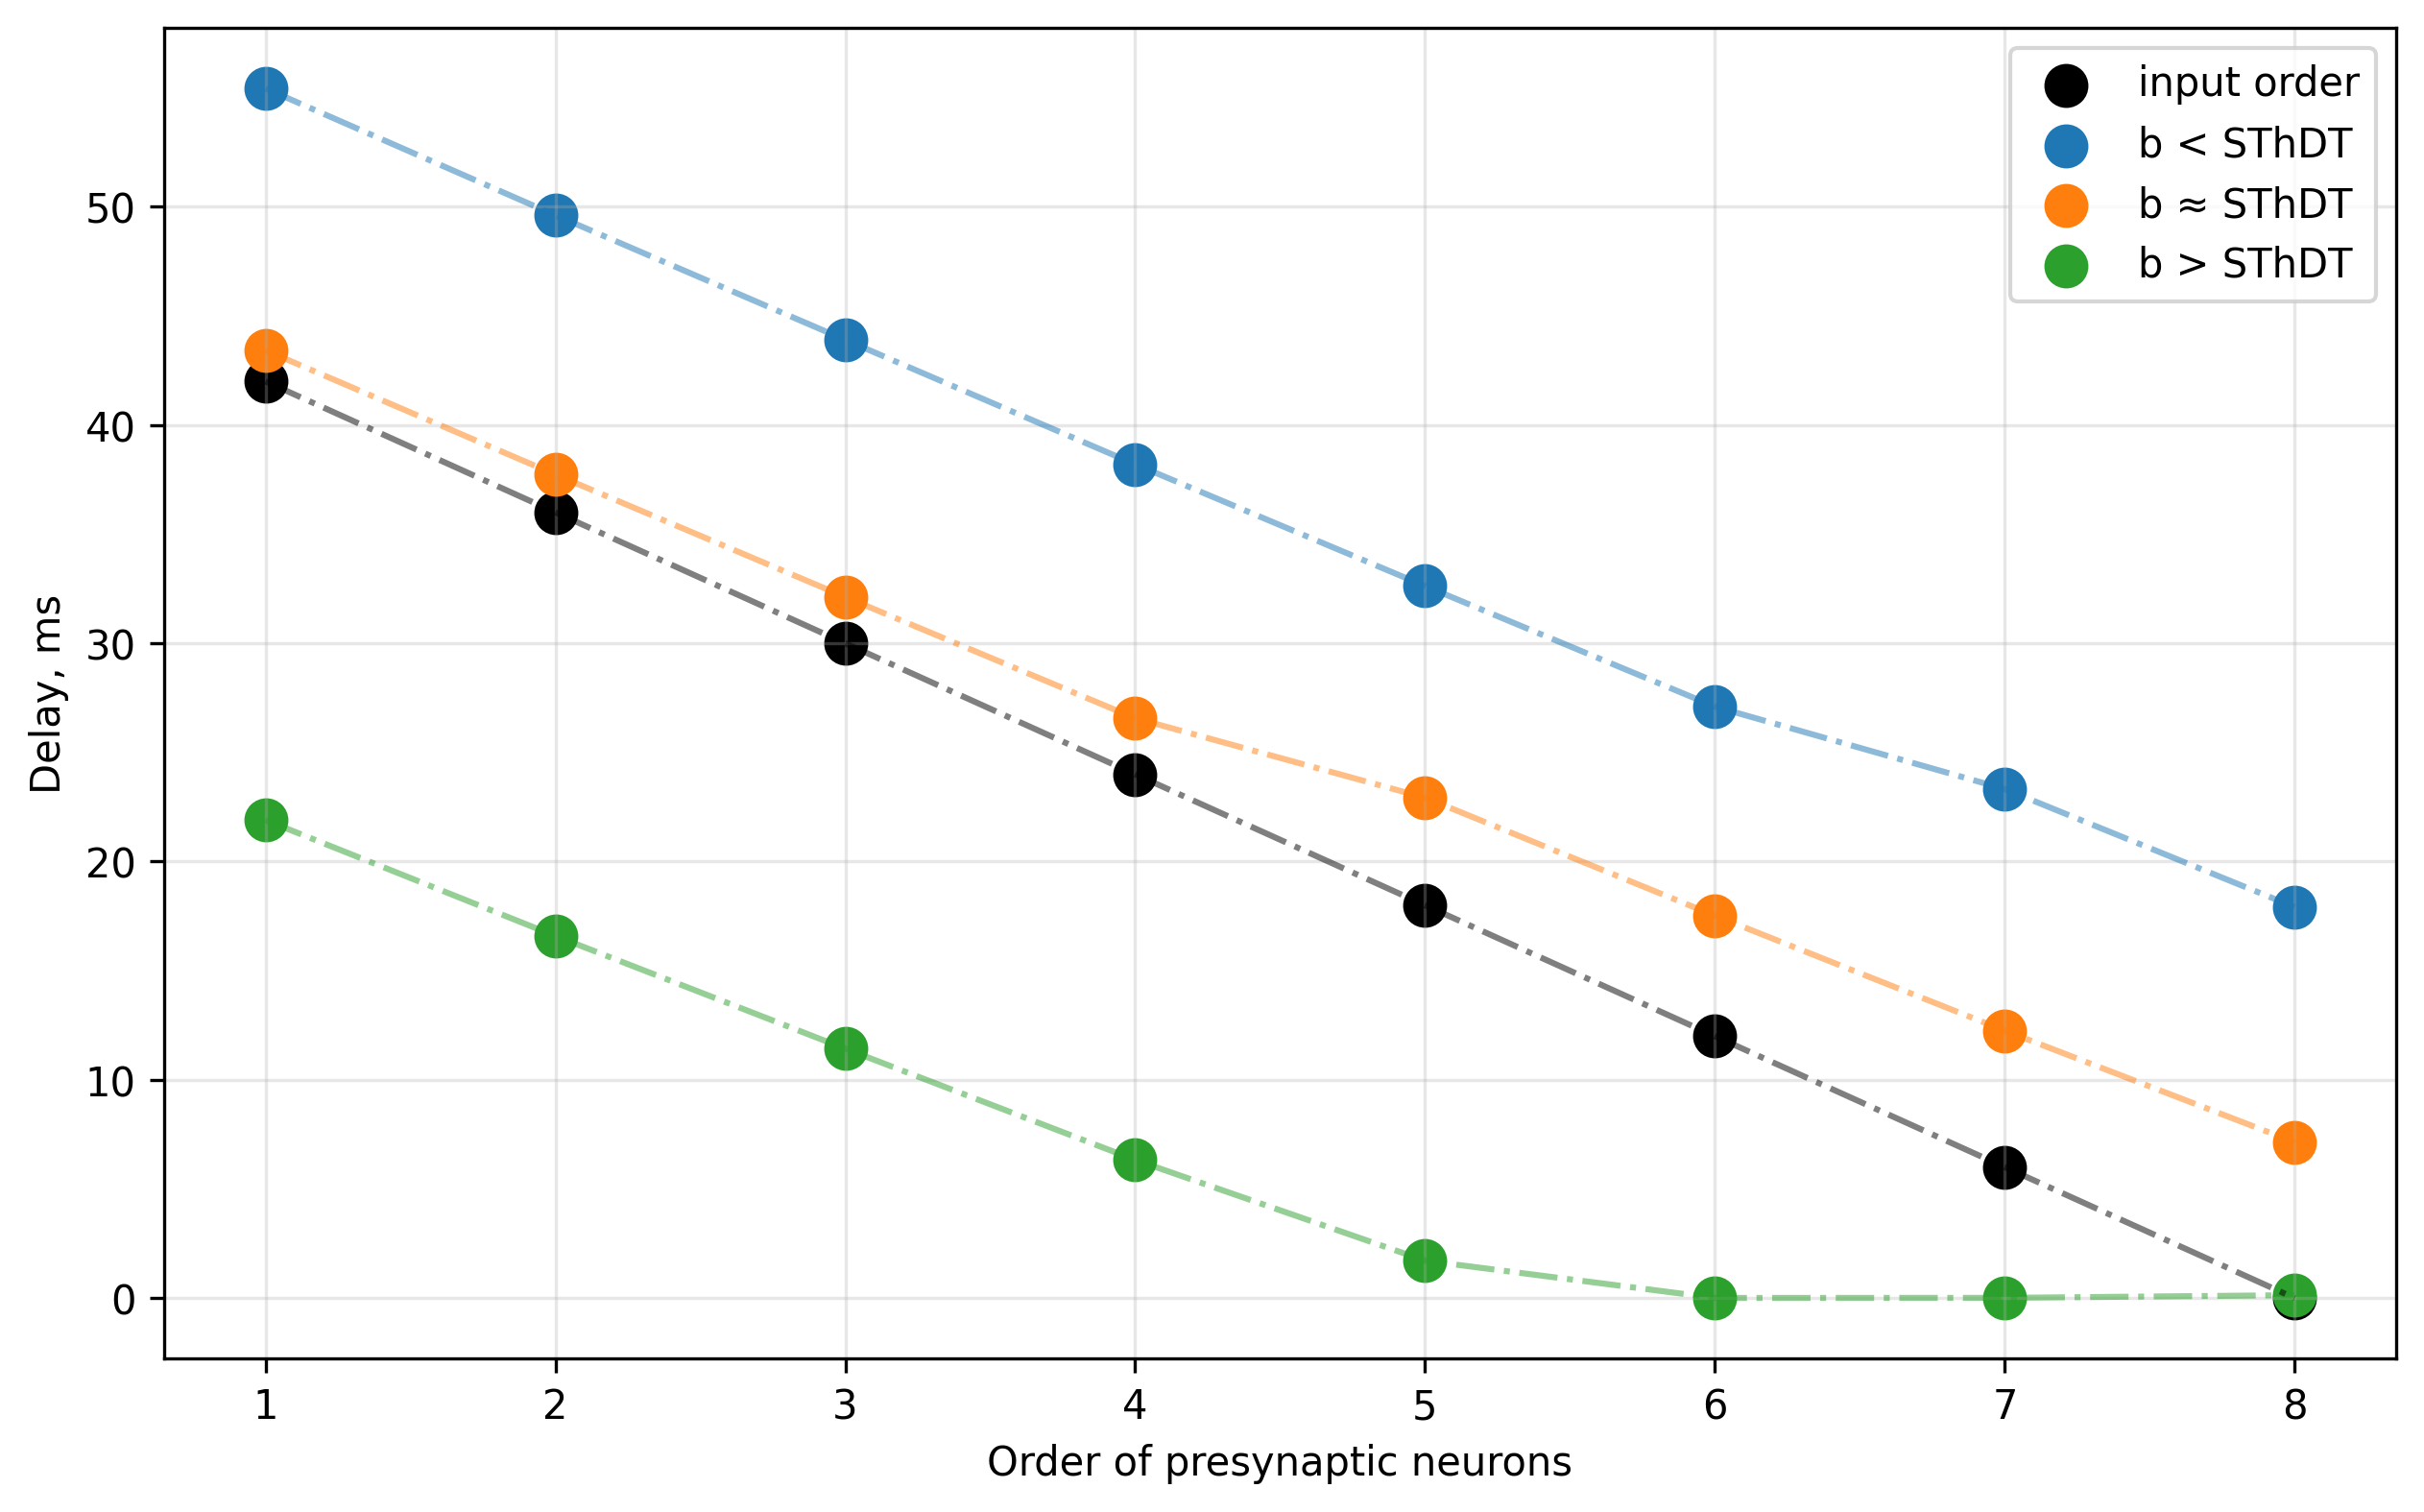

In [119]:
fig = plt.figure()
fig.set_figheight(6)
fig.set_figwidth(10)
fig.set_dpi(300)
plt.xlabel('Order of presynaptic neurons')
plt.ylabel('Delay, ms')
plt.grid(visible=True, alpha=.3)
plt.plot(list(range(1,num_inputs+1)),delays_less*res, '-.', alpha=.5)
plt.plot(list(range(1,num_inputs+1)),delays_close*res, '-.', alpha=.5)
plt.plot(list(range(1,num_inputs+1)),delays_greater*res, '-.', alpha=.5)
plt.plot(list(range(1, num_inputs+1)), [i*interval for i in range(num_inputs-1, -1, -1)], '-.', alpha=.5, c='black')
plt.scatter(list(range(1, num_inputs+1)), [i*interval for i in range(num_inputs-1, -1, -1)], label='input order', s=100, c='black')
plt.scatter(list(range(1,num_inputs+1)),delays_less*res, label='b < SThDT', s=100)
plt.scatter(list(range(1,num_inputs+1)),delays_close*res, label='b ≈ SThDT', s=100)
plt.scatter(list(range(1,num_inputs+1)),delays_greater*res, label='b > SThDT', s=100)
plt.legend(markerscale=1)
plt.show()